# Lyric Mood Classification - Baselines and CNN Results

In this notebook, we establish classification accuracies from the following classification strategies:
* Most-Common-Case
* Multinomial Naive-Bayes (NB)
* Support Vector Machines (SVM)
* Lyrics CNN (our model)

The first three will serve as baselines for the fourth, our own classifier.

For each of the above, we baseline with several forms of input:
* Unequalized Moods
* Unequalized Mood Quadrants
* Equalized Moods
* Equalized Mood Quadrants
* Equalized Training Moods, Unequalized Test Moods
* Equalized Training Mood Quadrants, Unequalized Test Mood Quadrants

Where "unequalized" vs "equalized" refers to oversampling the under represented mood categories to create a more evenly distributed dataset and "quadrants" refers to grouping the categories into four quadrants to eliminate overlap between the moods.

In [69]:
# Project Imports
from label_lyrics import CSV_LABELED_LYRICS_EXPANDED
from mood_classification import build_lyrics_dataset, split_data, split_x_y, pad_data
from mood_classification import mood_classification, word_tokenizers_ids
from utils import configure_logging

# Python and Package Imports
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk import WordPunctTokenizer, word_tokenize
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

%matplotlib inline

In [ ]:
# IMPORTANT: only run this once or else it will generate duplicate logs for each logging call!
configure_logging(logname='baselines_and_cnn_results')

In [70]:
# Helpers
def pprint_accuracy(acc):
    return '{0:.02f}%'.format(acc * 100)

## Baselining Functions

Here we define functions for each classifier to be used in the following sections that vary based on form of data input.

In [71]:
def _most_common_case_accuracy(x, y):
    total_count = len(x)
    common_count = pd.Series(y).value_counts().max()
    accuracy = common_count / total_count
    return accuracy
    
def most_common_case_classification(df_train, df_dev, df_test):
    train_acc = _most_common_case_accuracy(df_train.lyrics_filename, df_train.mood) 
    dev_acc = _most_common_case_accuracy(df_dev.lyrics_filename, df_dev.mood)
    test_acc = _most_common_case_accuracy(df_test.lyrics_filename, df_test.mood)
    print('Most-Common-Case Classifier Train Accuracy:', pprint_accuracy(train_acc))
    print('Most-Common-Case Classifier Dev Accuracy:', pprint_accuracy(dev_acc))
    print('Most-Common-Case Classifier Test Accuracy:', pprint_accuracy(test_acc))


In [72]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

def _prep_lyrics_for_nb(lyrics_series, count_vect=None, tfidf_transformer=None):
   # thank you: https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
    if not count_vect:
        count_vect = CountVectorizer()
        count_vect = count_vect.fit(lyrics_series)
    x_train_counts = count_vect.transform(lyrics_series)
    if not tfidf_transformer:
        tfidf_transformer = TfidfTransformer()
        tfidf_transformer = tfidf_transformer.fit(x_train_counts)
    x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)
    return count_vect, x_train_counts, tfidf_transformer, x_train_tfidf

def prep_lyrics_for_nb(train_lyrics, dev_lyrics, test_lyrics):
    # convert lyrics to counts and term-frequencies
    count_vect, x_train_counts, tfidf_transformer, x_train_tfidf = _prep_lyrics_for_nb(train_lyrics)
    #print(x_train_tfidf.shape)
    _, x_dev_counts, _, x_dev_tfidf = _prep_lyrics_for_nb(dev_lyrics, count_vect, tfidf_transformer)
    #print(x_dev_tfidf.shape)
    _, x_test_counts, _, x_test_tfidf = _prep_lyrics_for_nb(test_lyrics, count_vect, tfidf_transformer)
    #print(x_test_tfidf.shape)
    return x_train_tfidf, x_dev_tfidf, x_test_tfidf

def nb_classification(train_lyrics, y_train, dev_lyrics, y_dev, test_lyrics, y_test):
    x_train_tfidf, x_dev_tfidf, x_test_tfidf = prep_lyrics_for_nb(train_lyrics, dev_lyrics, test_lyrics)
    clf = MultinomialNB().fit(x_train_tfidf, y_train.astype('int')) 
    dev_acc = clf.score(x_dev_tfidf, y_dev.astype('int'))
    print('Naive Bayes Classifier Dev Accuracy:', pprint_accuracy(dev_acc))
    test_acc = clf.score(x_test_tfidf, y_test.astype('int'))
    print('Naive Bayes Classifier Test Accuracy:', pprint_accuracy(test_acc))

In [73]:
def svm_classification(train_lyrics, y_train, dev_lyrics, y_dev, test_lyrics, y_test):
    x_train_tfidf, x_dev_tfidf, x_test_tfidf = prep_lyrics_for_nb(train_lyrics, dev_lyrics, test_lyrics)
    clf = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42,
                max_iter=5, tol=None).fit(x_train_tfidf, y_train.astype('int'))
    dev_acc = clf.score(x_dev_tfidf, y_dev.astype('int'))
    print('SVM Classifier Dev Accuracy:', pprint_accuracy(dev_acc))
    test_acc = clf.score(x_test_tfidf, y_test.astype('int'))
    print('SVM Classifier Test Accuracy:', pprint_accuracy(test_acc))

In [94]:
def get_and_plot_x_y_data(quadrants, pad_lyric_data, pad_train_only=False):
    print('building dataset')
    df = build_lyrics_dataset(
        CSV_LABELED_LYRICS_EXPANDED,
        word_tokenize,
        quadrants=quadrants,
        pad_data_flag=pad_lyric_data and not pad_train_only)

    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(6,15))
    
    print('plotting moods')
    _ = df.mood.value_counts().plot(kind='bar', title='mood counts', ax=axes[0])

    print('splitting data')
    df_train, df_dev, df_test = split_data(df)
    
    if pad_lyric_data and pad_train_only:
        print('padding train data')
        df_train = pad_data(df_train)

    print('plotting train, dev, and test moods')
    _ = df_train.mood.value_counts().plot(kind='bar', title='train data mood counts', ax=axes[1])
    _ = df_dev.mood.value_counts().plot(kind='bar', title='dev data mood counts', ax=axes[2])
    _ = df_test.mood.value_counts().plot(kind='bar', title='test data mood counts', ax=axes[3])

    x_train, y_train, x_dev, y_dev, x_test, y_test = split_x_y(
        df_train, df_dev, df_test, x_col='preprocessed_lyrics')

    print('***\nMost-Common-Case\n')
    most_common_case_classification(
        df_train,
        df_dev,
        df_test)
    print('***\nMultinomial Naive-Bayes\n')
    nb_classification(
        df_train.lyrics, df_train.mood_cats,
        df_dev.lyrics, df_dev.mood_cats,
        df_test.lyrics, df_test.mood_cats)
    print('***\nSupport Vector Machines\n')
    svm_classification(
        df_train.lyrics, df_train.mood_cats,
        df_dev.lyrics, df_dev.mood_cats,
        df_test.lyrics, df_test.mood_cats)


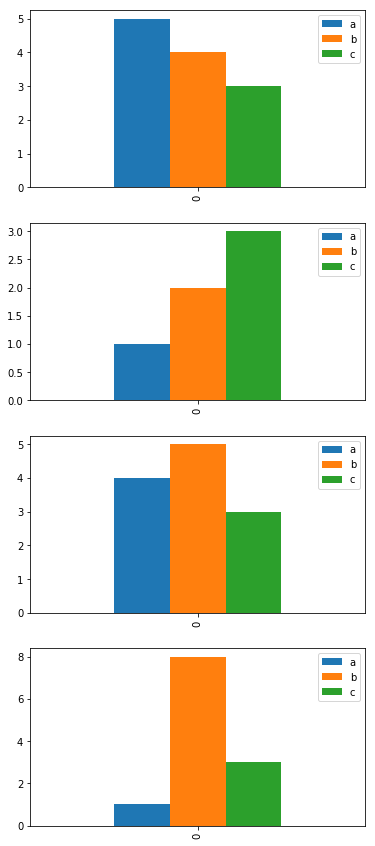

In [93]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(6,15))
df1 = pd.DataFrame({'a': [5], 'b': [4], 'c': [3]})
df2 = pd.DataFrame({'a': [1], 'b': [2], 'c': [3]})
df3 = pd.DataFrame({'a': [4], 'b': [5], 'c': [3]})
df4 = pd.DataFrame({'a': [1], 'b': [8], 'c': [3]})
df1.plot(kind='bar', ax=axes[0])
df2.plot(kind='bar', ax=axes[1])
df3.plot(kind='bar', ax=axes[2])
df4.plot(kind='bar', ax=axes[3])

## Unequalized Moods


### Baselines

building dataset
plotting moods
splitting data
***
Most-Common-Case

Most-Common-Case Classifier Train Accuracy: 40.07%
Most-Common-Case Classifier Dev Accuracy: 39.36%
Most-Common-Case Classifier Test Accuracy: 39.81%
***
Multinomial Naive-Bayes

Naive Bayes Classifier Dev Accuracy: 39.67%
Naive Bayes Classifier Test Accuracy: 39.93%
***
Support Vector Machines

SVM Classifier Dev Accuracy: 45.41%
SVM Classifier Test Accuracy: 44.88%


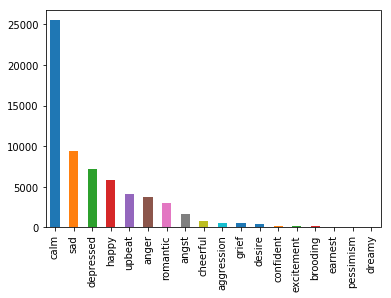

In [46]:
get_and_plot_x_y_data(quadrants=False, pad_lyric_data=False)

### CNN without lyrics2vec

In [ ]:
mood_classification(
    # Controls
    name='w2v0_unequalized-moods',
    regen_dataset=True,
    regen_lyrics2vec_dataset=True,
    use_pretrained_embeddings=False,    # do not use word2vec
    regen_pretrained_embeddings=False,  # do not generate embeddings
    revectorize_lyrics=True,
    skip_to_training=False,
    cnn_train_embeddings=True,          # let CNN train the randomly initialized embeddings
    quadrants=False,                    # no quadrants
    pad_data_flag=False,                # no padding
    pad_train_only=False,
    low_memory_mode=True,               # essentially turns off saving stuff
    launch_tensorboard=False,           # no need for tensorboard if we're just generating results
    # Model Hyperparameters             # we use params from our best experiment
    embedding_size=300,
    filter_sizes=[3,4,5],
    num_filters=300,
    dropout=0.8,
    l2_reg_lambda=0.01,
    # Training parameters
    batch_size=128,
    num_epochs=12,
    evaluate_every=100,
    checkpoint_every=100,
    num_checkpoints=5,
    # Embeddings parameters
    vocab_size=10000,
    word_tokenizer=word_tokenizers_ids[1],
)

### CNN with lyrics2vec

In [ ]:
mood_classification(
    # Controls
    name='w2v1_unequalized-moods',
    regen_dataset=True,
    regen_lyrics2vec_dataset=True,
    use_pretrained_embeddings=True,     # YES use word2vec
    regen_pretrained_embeddings=True,   # YES not generate embeddings
    revectorize_lyrics=True,
    skip_to_training=False,
    cnn_train_embeddings=True,          # let CNN train the randomly initialized embeddings
    quadrants=False,                    # no quadrants
    pad_data_flag=False,                # no padding
    pad_train_only=False,
    low_memory_mode=True,               # essentially turns off saving stuff
    launch_tensorboard=False,           # no need for tensorboard if we're just generating results
    # Model Hyperparameters             # we use params from our best experiment
    embedding_size=300,
    filter_sizes=[3,4,5],
    num_filters=300,
    dropout=0.8,
    l2_reg_lambda=0.01,
    # Training parameters
    batch_size=128,
    num_epochs=12,
    evaluate_every=100,
    checkpoint_every=100,
    num_checkpoints=5,
    # Embeddings parameters
    vocab_size=10000,
    word_tokenizer=word_tokenizers_ids[1],
)

## Unequalized Moods Quadrants

### Baselines

building dataset
plotting moods
splitting data
***
Most-Common-Case

Most-Common-Case Classifier Train Accuracy: 42.87%
Most-Common-Case Classifier Dev Accuracy: 42.78%
Most-Common-Case Classifier Test Accuracy: 43.61%
***
Multinomial Naive-Bayes

Naive Bayes Classifier Dev Accuracy: 45.95%
Naive Bayes Classifier Test Accuracy: 46.78%
***
Support Vector Machines

SVM Classifier Dev Accuracy: 51.29%
SVM Classifier Test Accuracy: 50.95%


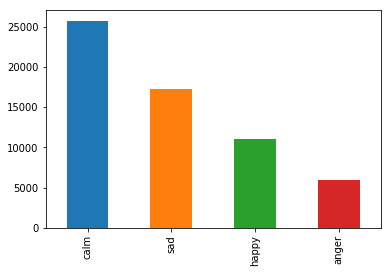

In [47]:
get_and_plot_x_y_data(quadrants=True, pad_lyric_data=False)

### CNN without lyrics2vec

In [ ]:
mood_classification(
    # Controls
    name='w2v0_unequalized-mood-quadrants',
    regen_dataset=True,
    regen_lyrics2vec_dataset=True,
    use_pretrained_embeddings=False,    # do not use word2vec
    regen_pretrained_embeddings=False,  # do not generate embeddings
    revectorize_lyrics=True,
    skip_to_training=False,
    cnn_train_embeddings=True,          # let CNN train the randomly initialized embeddings
    quadrants=True,                     # YES quadrants
    pad_data_flag=False,                # no padding
    pad_train_only=False,
    low_memory_mode=True,               # essentially turns off saving stuff
    launch_tensorboard=False,           # no need for tensorboard if we're just generating results
    # Model Hyperparameters             # we use params from our best experiment
    embedding_size=300,
    filter_sizes=[3,4,5],
    num_filters=300,
    dropout=0.8,
    l2_reg_lambda=0.01,
    # Training parameters
    batch_size=128,
    num_epochs=12,
    evaluate_every=100,
    checkpoint_every=100,
    num_checkpoints=5,
    # Embeddings parameters
    vocab_size=10000,
    word_tokenizer=word_tokenizers_ids[1],
)

### CNN with lyrics2vec

In [ ]:
mood_classification(
    # Controls
    name='w2v1_unequalized-mood-quadrants',
    regen_dataset=True,
    regen_lyrics2vec_dataset=True,
    use_pretrained_embeddings=True,     # YES use word2vec
    regen_pretrained_embeddings=True,   # YES generate embeddings
    revectorize_lyrics=True,
    skip_to_training=False,
    cnn_train_embeddings=True,          # let CNN train the randomly initialized embeddings
    quadrants=True,                     # YES quadrants
    pad_data_flag=False,                # no padding
    pad_train_only=False,
    low_memory_mode=True,               # essentially turns off saving stuff
    launch_tensorboard=False,           # no need for tensorboard if we're just generating results
    # Model Hyperparameters             # we use params from our best experiment
    embedding_size=300,
    filter_sizes=[3,4,5],
    num_filters=300,
    dropout=0.8,
    l2_reg_lambda=0.01,
    # Training parameters
    batch_size=128,
    num_epochs=12,
    evaluate_every=100,
    checkpoint_every=100,
    num_checkpoints=5,
    # Embeddings parameters
    vocab_size=10000,
    word_tokenizer=word_tokenizers_ids[1],
)

## Equalized Moods

### Baselines

building dataset
plotting moods
splitting data
***
Most-Common-Case

Most-Common-Case Classifier Train Accuracy: 5.59%
Most-Common-Case Classifier Dev Accuracy: 5.69%
Most-Common-Case Classifier Test Accuracy: 5.75%
***
Multinomial Naive-Bayes

Naive Bayes Classifier Dev Accuracy: 74.74%
Naive Bayes Classifier Test Accuracy: 74.63%
***
Support Vector Machines

SVM Classifier Dev Accuracy: 67.35%
SVM Classifier Test Accuracy: 67.28%


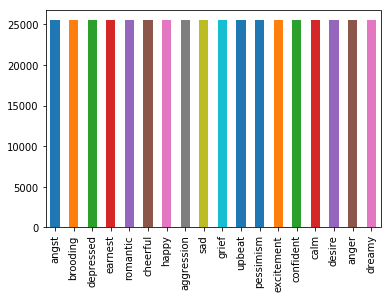

In [67]:
get_and_plot_x_y_data(quadrants=False, pad_lyric_data=True)

### CNN without lyrics2vec

In [ ]:
mood_classification(
    # Controls
    name='w2v0_equalized-moods',
    regen_dataset=True,
    regen_lyrics2vec_dataset=True,
    use_pretrained_embeddings=False,    # do not use word2vec
    regen_pretrained_embeddings=False,  # do not generate embeddings
    revectorize_lyrics=True,
    skip_to_training=False,
    cnn_train_embeddings=True,          # let CNN train the randomly initialized embeddings
    quadrants=False,                    # no quadrants
    pad_data_flag=True,                 # YES padding
    pad_train_only=False,
    low_memory_mode=True,               # essentially turns off saving stuff
    launch_tensorboard=False,           # no need for tensorboard if we're just generating results
    # Model Hyperparameters             # we use params from our best experiment
    embedding_size=300,
    filter_sizes=[3,4,5],
    num_filters=300,
    dropout=0.8,
    l2_reg_lambda=0.01,
    # Training parameters
    batch_size=128,
    num_epochs=12,
    evaluate_every=100,
    checkpoint_every=100,
    num_checkpoints=5,
    # Embeddings parameters
    vocab_size=10000,
    word_tokenizer=word_tokenizers_ids[1],
)

### CNN with lyrics2vec

In [ ]:
mood_classification(
    # Controls
    name='w2v1_equalized-moods',
    regen_dataset=True,
    regen_lyrics2vec_dataset=True,
    use_pretrained_embeddings=True,     # YES use word2vec
    regen_pretrained_embeddings=True,   # YES generate embeddings
    revectorize_lyrics=True,
    skip_to_training=False,
    cnn_train_embeddings=True,          # let CNN train the randomly initialized embeddings
    quadrants=False,                    # no quadrants
    pad_data_flag=True,                 # YES padding
    pad_train_only=False,
    low_memory_mode=True,               # essentially turns off saving stuff
    launch_tensorboard=False,           # no need for tensorboard if we're just generating results
    # Model Hyperparameters             # we use params from our best experiment
    embedding_size=300,
    filter_sizes=[3,4,5],
    num_filters=300,
    dropout=0.8,
    l2_reg_lambda=0.01,
    # Training parameters
    batch_size=128,
    num_epochs=12,
    evaluate_every=100,
    checkpoint_every=100,
    num_checkpoints=5,
    # Embeddings parameters
    vocab_size=10000,
    word_tokenizer=word_tokenizers_ids[1],
)

## Equalized Mood Quadrants

### Baselines

building dataset
plotting moods
splitting data
***
Most-Common-Case

Most-Common-Case Classifier Train Accuracy: 25.13%
Most-Common-Case Classifier Dev Accuracy: 25.34%
Most-Common-Case Classifier Test Accuracy: 25.34%
***
Multinomial Naive-Bayes

Naive Bayes Classifier Dev Accuracy: 55.32%
Naive Bayes Classifier Test Accuracy: 55.19%
***
Support Vector Machines

SVM Classifier Dev Accuracy: 54.28%
SVM Classifier Test Accuracy: 54.07%


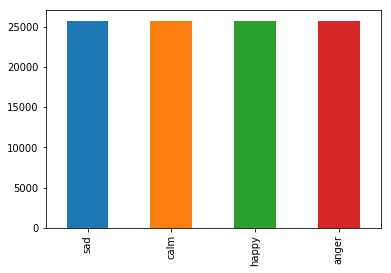

In [68]:
get_and_plot_x_y_data(quadrants=True, pad_lyric_data=True)

### CNN without lyrics2vec

In [ ]:
mood_classification(
    # Controls
    name='w2v0_equalized-mood-quadrants',
    regen_dataset=True,
    regen_lyrics2vec_dataset=True,
    use_pretrained_embeddings=False,    # do not use word2vec
    regen_pretrained_embeddings=False,  # do not generate embeddings
    revectorize_lyrics=True,
    skip_to_training=False,
    cnn_train_embeddings=True,          # let CNN train the randomly initialized embeddings
    quadrants=True,                     # YES quadrants
    pad_data_flag=True,                 # YES padding
    pad_train_only=False,
    low_memory_mode=True,               # essentially turns off saving stuff
    launch_tensorboard=False,           # no need for tensorboard if we're just generating results
    # Model Hyperparameters             # we use params from our best experiment
    embedding_size=300,
    filter_sizes=[3,4,5],
    num_filters=300,
    dropout=0.8,
    l2_reg_lambda=0.01,
    # Training parameters
    batch_size=128,
    num_epochs=12,
    evaluate_every=100,
    checkpoint_every=100,
    num_checkpoints=5,
    # Embeddings parameters
    vocab_size=10000,
    word_tokenizer=word_tokenizers_ids[1],
)

### CNN with lyrics2vec

In [ ]:
mood_classification(
    # Controls
    name='w2v1_equalized-mood-quadrants',
    regen_dataset=True,
    regen_lyrics2vec_dataset=True,
    use_pretrained_embeddings=True,    # YES use word2vec
    regen_pretrained_embeddings=True,  # YES generate embeddings
    revectorize_lyrics=True,
    skip_to_training=False,
    cnn_train_embeddings=True,          # let CNN train the randomly initialized embeddings
    quadrants=True,                     # YES quadrants
    pad_data_flag=True,                 # YES padding
    pad_train_only=False,
    low_memory_mode=True,               # essentially turns off saving stuff
    launch_tensorboard=False,           # no need for tensorboard if we're just generating results
    # Model Hyperparameters             # we use params from our best experiment
    embedding_size=300,
    filter_sizes=[3,4,5],
    num_filters=300,
    dropout=0.8,
    l2_reg_lambda=0.01,
    # Training parameters
    batch_size=128,
    num_epochs=12,
    evaluate_every=100,
    checkpoint_every=100,
    num_checkpoints=5,
    # Embeddings parameters
    vocab_size=10000,
    word_tokenizer=word_tokenizers_ids[1],
)

# Equalized Training Moods, Unequalized Test Moods

### Baselines

In [ ]:
get_and_plot_x_y_data(quadrants=False, pad_lyric_data=True, pad_train_only=True)

building dataset
plotting moods
splitting data
padding train data
plotting train, dev, and test moods
***
Most-Common-Case

Most-Common-Case Classifier Train Accuracy: 5.56%
Most-Common-Case Classifier Dev Accuracy: 39.14%
Most-Common-Case Classifier Test Accuracy: 40.68%
***
Multinomial Naive-Bayes



### CNN without lyrics2vec

In [ ]:
mood_classification(
    # Controls
    name='w2v0_equalized-training-moods-unequalized-test-moods',
    regen_dataset=True,
    regen_lyrics2vec_dataset=True,
    use_pretrained_embeddings=False,    # do not use word2vec
    regen_pretrained_embeddings=False,  # do not generate embeddings
    revectorize_lyrics=True,
    skip_to_training=False,
    cnn_train_embeddings=True,          # let CNN train the randomly initialized embeddings
    quadrants=False,                    # no quadrants
    pad_data_flag=True,                 # YES padding
    pad_train_only=True,                # but ONLY on train data!
    low_memory_mode=True,               # essentially turns off saving stuff
    launch_tensorboard=False,           # no need for tensorboard if we're just generating results
    # Model Hyperparameters             # we use params from our best experiment
    embedding_size=300,
    filter_sizes=[3,4,5],
    num_filters=300,
    dropout=0.8,
    l2_reg_lambda=0.01,
    # Training parameters
    batch_size=128,
    num_epochs=12,
    evaluate_every=100,
    checkpoint_every=100,
    num_checkpoints=5,
    # Embeddings parameters
    vocab_size=10000,
    word_tokenizer=word_tokenizers_ids[1],
)

### CNN with lyrics2vec

In [ ]:
mood_classification(
    # Controls
    name='w2v1_equalized-training-moods-unequalized-test-moods',
    regen_dataset=True,
    regen_lyrics2vec_dataset=True,
    use_pretrained_embeddings=True,     # YES use word2vec
    regen_pretrained_embeddings=True,   # YES generate embeddings
    revectorize_lyrics=True,
    skip_to_training=False,
    cnn_train_embeddings=True,          # let CNN train the randomly initialized embeddings
    quadrants=False,                    # no quadrants
    pad_data_flag=True,                 # YES padding
    pad_train_only=True,                # but ONLY on train data!
    low_memory_mode=True,               # essentially turns off saving stuff
    launch_tensorboard=False,           # no need for tensorboard if we're just generating results
    # Model Hyperparameters             # we use params from our best experiment
    embedding_size=300,
    filter_sizes=[3,4,5],
    num_filters=300,
    dropout=0.8,
    l2_reg_lambda=0.01,
    # Training parameters
    batch_size=128,
    num_epochs=12,
    evaluate_every=100,
    checkpoint_every=100,
    num_checkpoints=5,
    # Embeddings parameters
    vocab_size=10000,
    word_tokenizer=word_tokenizers_ids[1],
)

# Equalized Training Mood Quadrants, Unequalized Test Mood Quadrants

### Baselines

In [ ]:
get_and_plot_x_y_data(quadrants=True, pad_lyric_data=True, pad_train_only=True)

### CNN without lyrics2vec

In [ ]:
mood_classification(
    # Controls
    name='w2v0_equalized-training-mood-quadrants-unequalized-test-mood-quadrants',
    regen_dataset=True,
    regen_lyrics2vec_dataset=True,
    use_pretrained_embeddings=False,    # do not use word2vec
    regen_pretrained_embeddings=False,  # do not generate embeddings
    revectorize_lyrics=True,
    skip_to_training=False,
    cnn_train_embeddings=True,          # let CNN train the randomly initialized embeddings
    quadrants=True,                     # YES quadrants
    pad_data_flag=True,                 # YES padding
    pad_train_only=True,                # but ONLY on train data!
    low_memory_mode=True,               # essentially turns off saving stuff
    launch_tensorboard=False,           # no need for tensorboard if we're just generating results
    # Model Hyperparameters             # we use params from our best experiment
    embedding_size=300,
    filter_sizes=[3,4,5],
    num_filters=300,
    dropout=0.8,
    l2_reg_lambda=0.01,
    # Training parameters
    batch_size=128,
    num_epochs=12,
    evaluate_every=100,
    checkpoint_every=100,
    num_checkpoints=5,
    # Embeddings parameters
    vocab_size=10000,
    word_tokenizer=word_tokenizers_ids[1],
)

### CNN with lyrics2vec

In [ ]:
mood_classification(
    # Controls
    name='w2v1_equalized-training-mood-quadrants-unequalized-test-mood-quadrants',
    regen_dataset=True,
    regen_lyrics2vec_dataset=True,
    use_pretrained_embeddings=True,     # YES use word2vec
    regen_pretrained_embeddings=True,   # YES generate embeddings
    revectorize_lyrics=True,
    skip_to_training=False,
    cnn_train_embeddings=True,          # let CNN train the randomly initialized embeddings
    quadrants=True,                     # YES quadrants
    pad_data_flag=True,                 # YES padding
    pad_train_only=True,                # but ONLY on train data!
    low_memory_mode=True,               # essentially turns off saving stuff
    launch_tensorboard=False,           # no need for tensorboard if we're just generating results
    # Model Hyperparameters             # we use params from our best experiment
    embedding_size=300,
    filter_sizes=[3,4,5],
    num_filters=300,
    dropout=0.8,
    l2_reg_lambda=0.01,
    # Training parameters
    batch_size=128,
    num_epochs=12,
    evaluate_every=100,
    checkpoint_every=100,
    num_checkpoints=5,
    # Embeddings parameters
    vocab_size=10000,
    word_tokenizer=word_tokenizers_ids[1],
)